# Book Recommendation System Using Collaborative Filtering

We are developing a book recommendation system based on the tags which are given by users to the books. 

The data was gathered from https://www.kaggle.com/zygmunt/goodbooks-10k

Are you wondering why tags and not user ratings?

A user doesnt usually stick to one genre of books which leads to obscure recommendations since the user might have rated different genres of books.

We wanted to make a recommendation system based on the genres of the book and hence we decided to use the userdefined tags


# Defining functions
Writing down all the functions in the beginning to run them effectively at the end

In [1]:
def recommendation(title):
    ''' Function to get recommendation for any books '''
    book = books_list.index(title)
    corr_book = corr_mat[book]
    corr_dataframe = pd.DataFrame({'books':books_list,'corr_book' : corr_book})
    images = (list(corr_dataframe[corr_dataframe['corr_book']>0.95].sort_values('corr_book',ascending=False)['books']))
    images = [item for item in images if item !=title]
    images = images[:10]
    images1 = images[:8]
    if len(images1) %2 != 0:
        images1 = images1[:-1]
    fig, ax = plt.subplots(nrows=round(len(images1)/2), ncols=2,figsize=(20,30))
    for i in range(len(images1)):
        URL = url.loc[images[i]][0]
        response = requests.get(URL)
        img = Image.open(BytesIO(response.content))
        plt.subplot(int(len(images1)/2), 2, (i+1))
        plt.axis('off')
        plt.title(images1[i],{'fontsize': 18, 'fontweight':'bold'})
        plt.imshow(img)
    plt.savefig('Poster',dpi=150)   
    for i in range(len(images)):
        print(images[i],'\t')

In [2]:
def verification(title):
    ''' Checking how many tags are presents in the recommended book as the book whose recommendation is gotten''' 
    book = books_list.index(title)
    corr_book = corr_mat[book]
    corr_dataframe = pd.DataFrame({'books':books_list,'corr_book' : corr_book})
    corr_books = (list(corr_dataframe[corr_dataframe['corr_book']>0.50].sort_values('corr_book',ascending=False)['books']))
    corr_books = [item for item in corr_books if item !=title]
    corr_books = corr_books[:5]
    title_tag = list(final_books['tag_name'][final_books['title']== title])
    dictionary = {}
    accuracy = 0
    for i in range(len(corr_books)):
        dictionary[corr_books[i]] = set(list(final_books['tag_name'][final_books['title']==corr_books[i]]))
    for key, value in dictionary.items():
        title_tag = list(final_books['tag_name'][final_books['title']== title])
        count = 0
        for i in value:
            if i in title_tag:
                count=count+1
        #print(key, ' matches ', count/len(title_tag)*100,'% with ', title)
        accuracy = accuracy + count/len(title_tag)
    return ((accuracy/len(corr_books)))
        

In [3]:
def randomrecommendation(title):
    ''' Generating Recommendation based on highest tag '''  
    top_tag = list(final_books1[final_books1['title']==title].sort_values('count',ascending=False).head(1).tag_name)
    top_recommended = list(final_books1[final_books1['tag_name']==top_tag[0]].sort_values('count',ascending = False).title.head(5))
    top_recommended = [item for item in top_recommended if item !=title]
    print(top_recommended)
    

In [4]:
def randomrecommendationverification(title):
    ''' Checking the tags in the random recommendation system ''' 
    top_tag = list(final_books1[final_books1['title']==title].sort_values('count',ascending=False).head(1).tag_name)
    top_recommended = list(final_books1[final_books1['tag_name']==top_tag[0]].sort_values('count',ascending = False).title.head(5))
    top_recommended = [item for item in top_recommended if item !=title]
    dictionary = {}
    accuracy = 0
    for i in range(len(top_recommended)):
        dictionary[top_recommended[i]] = set(list(final_books1['tag_name'][final_books1['title']==top_recommended[i]]))
    for key, value in dictionary.items():
        title_tag = set(list(final_books1['tag_name'][final_books1['title']== title]))
        count = 0
        for i in value:
            if i in title_tag:
                count=count+1
        #print(key, ' matches ', count/len(title_tag)*100,'% with ', title)
        accuracy = accuracy + count/len(title_tag)
    return ((accuracy/len(top_recommended)))

# Importing all the necessary modules

In [28]:


import pandas as pd
from pandas import Series, DataFrame
from sklearn.decomposition import TruncatedSVD
import numpy as np
import scipy.linalg as SL
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d, Axes3D 

In [6]:
#Importing the dataset
books = pd.read_csv('books.csv')
#Deelting the columns which are repetative and not used in the program
del books['work_text_reviews_count']
del books['ratings_count']
del books['best_book_id']
del books['isbn13']
del books['isbn']
del books['original_title']
del books['small_image_url']

#english language only
lang = ['eng', 'en-US','en-GB','en-CA','en']
books= books[books['language_code'].isin(lang)]

#Creating a dataframe with the title and the urls for the recommendation system 

url = books[['image_url','title']]
url = url.set_index('title')

#deleting those columns from the books dataframe
del books['image_url']
del books['language_code']

In [7]:
#Importing the dataset with information about the tags
tags = pd.read_csv('tags.csv')

#Importing the dataset with tags and books
book_tag= pd.read_csv('book_tags.csv')


In [8]:
#Merging the above two to make a dataset of book_tags along with the tag names
book_tags = pd.merge(book_tag,tags,on='tag_id',how='left')

#Removing all the tags that isnt alphanumerical 
book_tags=book_tags[~book_tags['tag_name'].str.contains(r'[^\x00-\x7F]+')]

#Choosing tags which describes each and everybook
tgs= ['erotica','historical-fiction','drama','historical','history','war','fantasy','young-adult', 'fiction','adventure', 'children', 'children-s', 'sci-fi-fantasy',
       'childhood','children-s-books', 'kids','fantasy-sci-fi','fantasy-sci-fi', 'ya-fantasy','teen', 
     'supernatural', 'mystery','ya-fiction','young-adult-fiction','women','mythology',
       'scifi-fantasy','romance', 'science-fiction-fantasy','fantasy-scifi', 'classic','action', 'sci-fi',
     'friendship', 'love', 'humor', 'contemporary-fiction', 'thriller','science-fiction', 'funny','action-adventure', 'scifi',
       'comedy', 'humour', 'adult', 'adult-fiction', 'literature', 'science','philosophy','history', 'nonfiction', 'non-fiction', 'historical',
     'family','drama', 'high-school', 'women','suspense','crime','erotica','religion', 'politics',
     'horror', 'crime', 'suspense', 'mystery-thriller','horror','paranormal','memoir',
       'memoirs', 'biography', 'biography-memoir', 'memoir-biography',
       'animals', 'autobiography', 'favorites', 'favorites', 'all-time-favorites', 'favorite-books', 'favorite', 'faves', 'my-favorites', 'favs',
       'thrillers', 'stand-alone', 'mysteries','mystery-crime', 'mystery-suspense', 'crime-mystery','suspense-thriller']
book_tags=book_tags[book_tags['tag_name'].isin(tgs)]


# There were various ways in which people write tags hence We decided to standardize to one name for each similar ones

In [9]:


scififantasy = 'sci-fi-fantasy fantasy-sci-fi science-fiction-fantasy fantasy-scifi scifi-fantasy'
scififantasy = scififantasy.split()
fiction = ['ya-fiction','fiction']
scifi = 'scifi science-fiction sci-fi'
scifi = scifi.split()
nonfiction = 'nonfiction non-fiction'
nonfiction = nonfiction.split()
children = 'children children-s children-s-books kids'
children = children.split()
crime_mystery = 'mystery-crime crime-mystery'
crime_mystery = crime_mystery.split()
mystery = ['mysteries', 'mystery']
thriller = ['thriller','thrillers']
humor = ['humor', 'humour']
novel =['novel','novels']
history = ['historical','history']
biography = ['memoir',
       'memoirs', 'biography', 'biography-memoir', 'memoir-biography',
       'animals', 'autobiography']
favorite = [ 'favorites', 'favorites', 'all-time-favorites', 'favorite-books', 'favorite', 'faves', 'my-favorites', 'favs']
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'scififantasy' if x in scififantasy else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'scifi' if x in scifi else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'nonfiction' if x in nonfiction else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'children' if x in children else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'crime_mystery' if x in crime_mystery else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'mystery' if x in mystery else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'thriller' if x in thriller else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'humor' if x in humor else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'fiction' if x in fiction else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'history' if x in history else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'biography' if x in biography else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'favorite' if x in favorite else x)

In [10]:
#creating a final dataframe with books and their tags 

final_books = pd.merge(books,book_tags,on='goodreads_book_id', how='left')
del final_books['goodreads_book_id']
del final_books['books_count']
del final_books['authors']
del final_books['tag_id']
del final_books['original_publication_year']
del final_books['work_id']
del final_books['book_id']
del final_books['ratings_1']
del final_books['ratings_2']
del final_books['ratings_3']
del final_books['ratings_4']
del final_books['ratings_5']
del final_books['average_rating']

#Creating a copy for the random recommendation system 
final_books1 = final_books.copy()
del final_books['count']

#Deleting all the duplicates if any
final_books = final_books.drop_duplicates()

# To make the collaborative filtering we used SVD for which we needed a pivoted dataframe with index as the book name and columns as the tag names

In [11]:

final_pivot = final_books.pivot_table(columns=['tag_name'],
                                      index=['title'],
                                     fill_value=0,
                                     aggfunc='count')
final_pivot = pd.DataFrame(final_pivot['work_ratings_count'])

#reseting index and setting it to book name
final_pivot = final_pivot.reset_index()
final_pivot=final_pivot.set_index('title')

In [12]:
#Using truncated SVD with 15 components to find eigen values of the books and the tags
SVD = TruncatedSVD(n_components=15,random_state=123)
resultant_matrix = SVD.fit_transform(final_pivot)

#finding the correlation between all the books based on their tags
corr_mat=np.corrcoef(resultant_matrix)

In [13]:
#Creating a booklist to seel
books_names = final_pivot.index
books_list = list(books_names)

# Our own way of checking the accuracy of recommendation system with a random recommendation system :)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


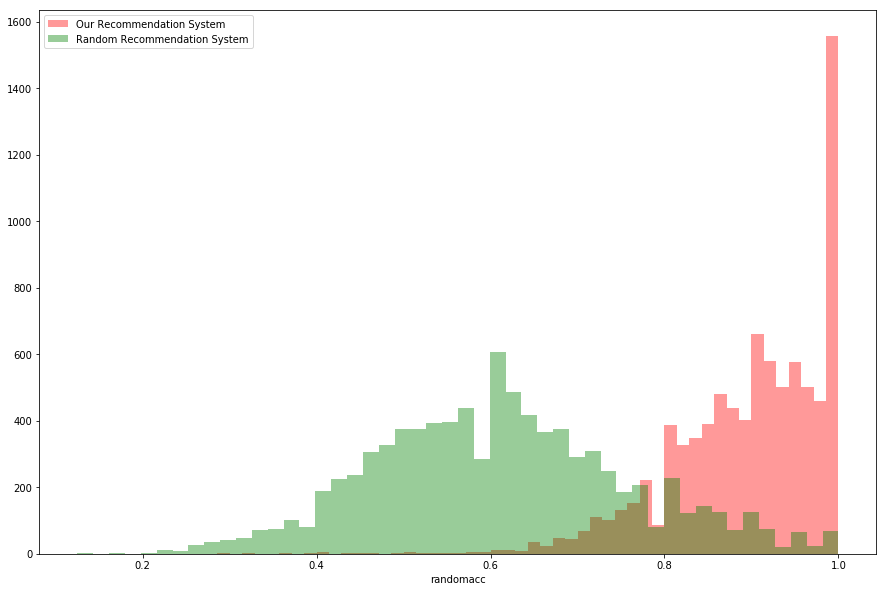

In [14]:
#verifying the accuracy between the randomrecommendation and OUR recommendation system
comparison= pd.DataFrame()
comparison['title'] = final_books['title'].unique()
comparison['acc'] = comparison['title'].apply(verification)
comparison['randomacc'] = comparison['title'].apply(randomrecommendationverification)


#Our Recommendation system vs Random Recommendation system comparison
sns.distplot(comparison['acc'],kde=False, color='r',)
sns.distplot(comparison['randomacc'],kde=False,color='g')
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.legend(['Our Recommendation System','Random Recommendation System'])
plt.savefig('Poster2',dpi=150) 

In [15]:
#To make it easier instead of typing the entier exact name of the book we made it easy
select_list = []
for book in books_list:
    if 'Harry Potter' in book:
        select_list.append(book)
print(select_list)

['Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)', 'Harry Potter Boxset (Harry Potter, #1-7)', 'Harry Potter Collection (Harry Potter, #1-6)', 'Harry Potter Schoolbooks Box Set: Two Classic Books from the Library of Hogwarts School of Witchcraft and Wizardry', 'Harry Potter and the Chamber of Secrets (Harry Potter, #2)', 'Harry Potter and the Cursed Child - Parts One and Two (Harry Potter, #8)', 'Harry Potter and the Deathly Hallows (Harry Potter, #7)', 'Harry Potter and the Goblet of Fire (Harry Potter, #4)', 'Harry Potter and the Half-Blood Prince (Harry Potter, #6)', 'Harry Potter and the Order of the Phoenix (Harry Potter, #5)', 'Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)', "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)", 'Harry Potter: Film Wizardry', 'Harry, a History: The True Story of a Boy Wizard, His Fans, and Life Inside the Harry Potter Phenomenon', 'The Harry Potter Collection 1-4 (Harry Potter, #1-4)', 'The Magical Worlds of Harry Potte

Harry Potter and the Sorcerer's Stone (Harry Potter, #1) 	
Harry Potter and the Goblet of Fire (Harry Potter, #4) 	
Harry Potter and the Prisoner of Azkaban (Harry Potter, #3) 	
The Dark Is Rising (The Dark is Rising, #2) 	
Harry Potter and the Deathly Hallows (Harry Potter, #7) 	
Sandry's Book (Circle of Magic, #1) 	
The Ironwood Tree (The Spiderwick Chronicles, #4) 	
The Tales of Beedle the Bard 	
Charlie Bone and the Invisible Boy (The Children of the Red King, #3) 	
Midnight for Charlie Bone (The Children of the Red King, #1) 	


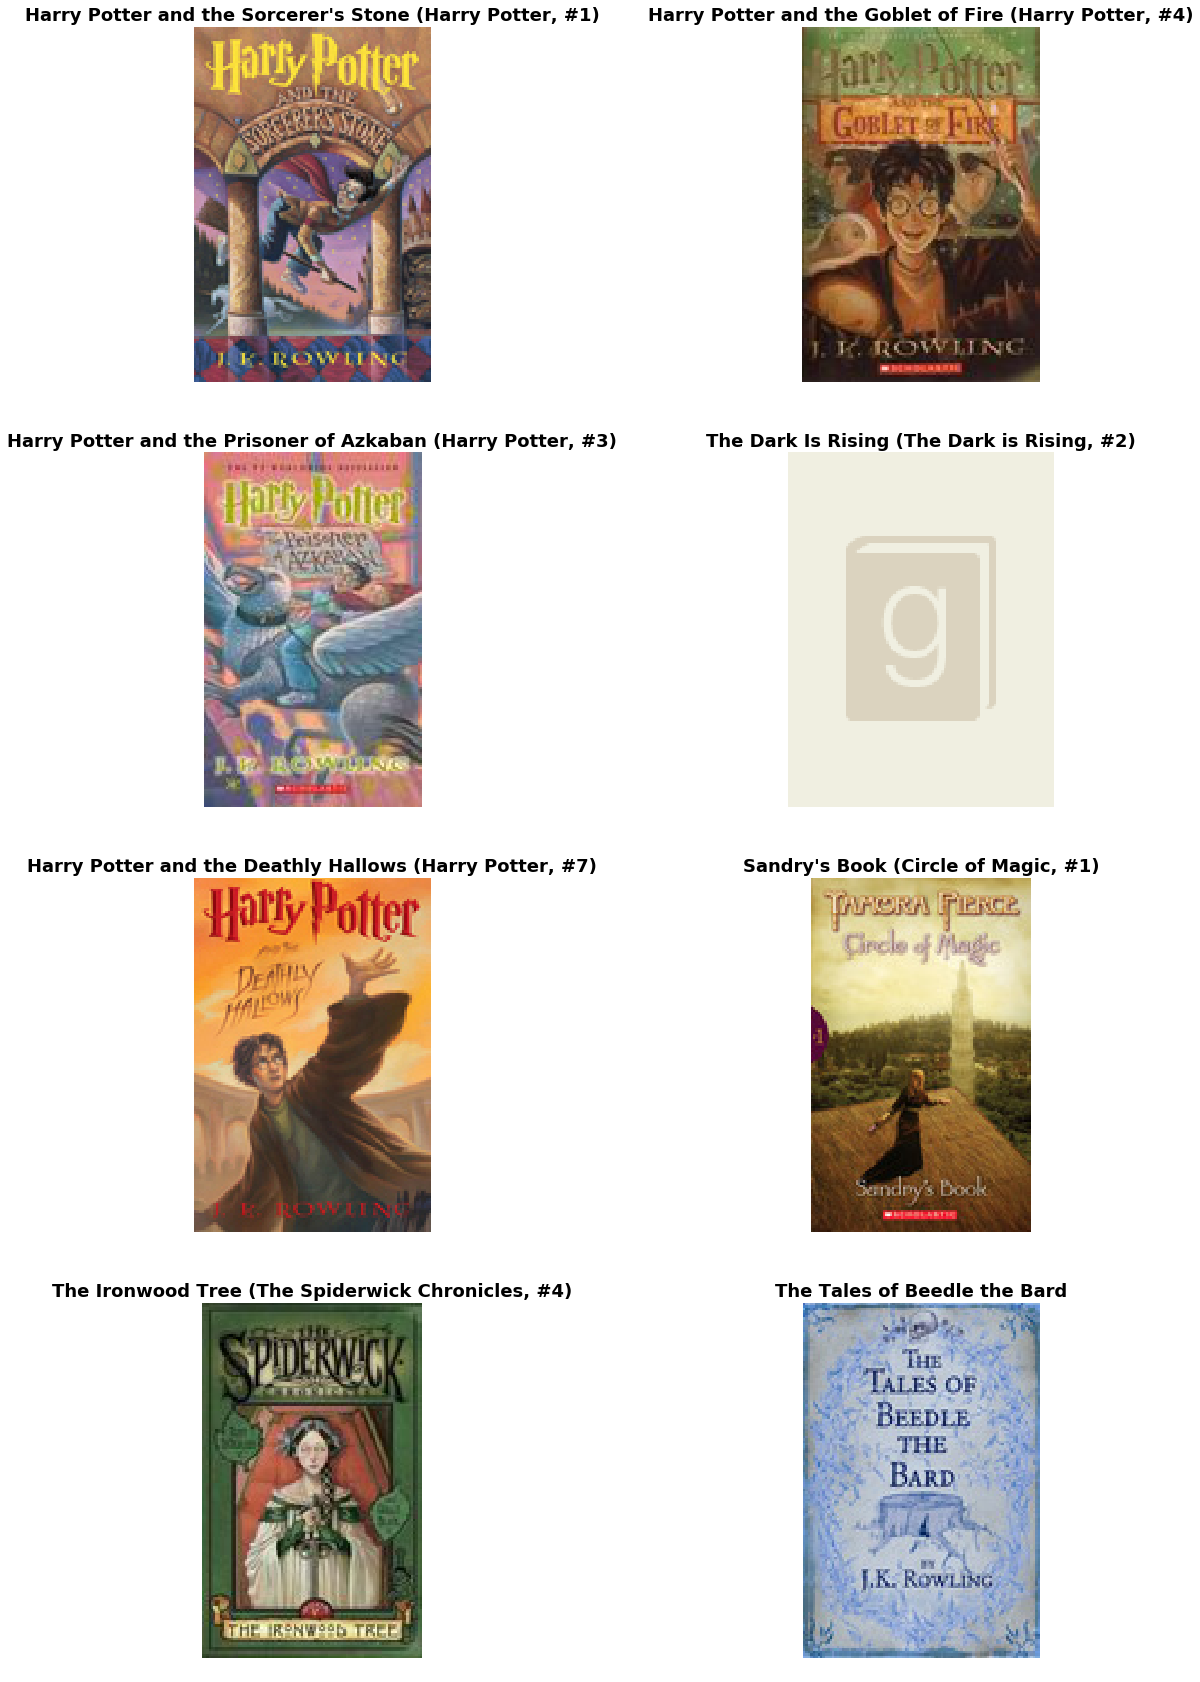

In [16]:
#Fetchiching recommendation for the book
recommendation(select_list[4])

# Clustering similar kinds of books together
Our Book recommedation system was based on correlation hence we wanted to show the books that are similar also get clustered together

In [17]:
ml_df = final_pivot.reset_index()
ml_df = pd.merge(ml_df, books[['title', 'average_rating','work_ratings_count']],on = 'title', how='left')

#For computationation reasons choosing a subset of books
ml_df = ml_df[(ml_df['average_rating']>4.0) & (ml_df['work_ratings_count']>50000)]

Since Machine learning Algorithms work on arrays converting the dataframe into arrays

In [18]:
#removing favorite and fiction as they do not add a lot of value to the similarity of the books
X = ml_df.drop(['title','average_rating','work_ratings_count','fiction','favorite'],axis=1).as_matrix()
y = list(ml_df['title'])
ml_df = ml_df.drop(['average_rating','work_ratings_count','fiction','favorite'],axis=1)

In [19]:
# Import KMeans
from sklearn.cluster import KMeans

# Create a KMeans instance with 3 clusters: model
model = KMeans(n_clusters = 6)

# Fit model to points
model.fit(X)

# Determine the cluster labels of new_points: labels
labels = model.predict(X)
ml_df['labels'] = labels
ml_df['labels'] =ml_df['labels'].astype(str)
 

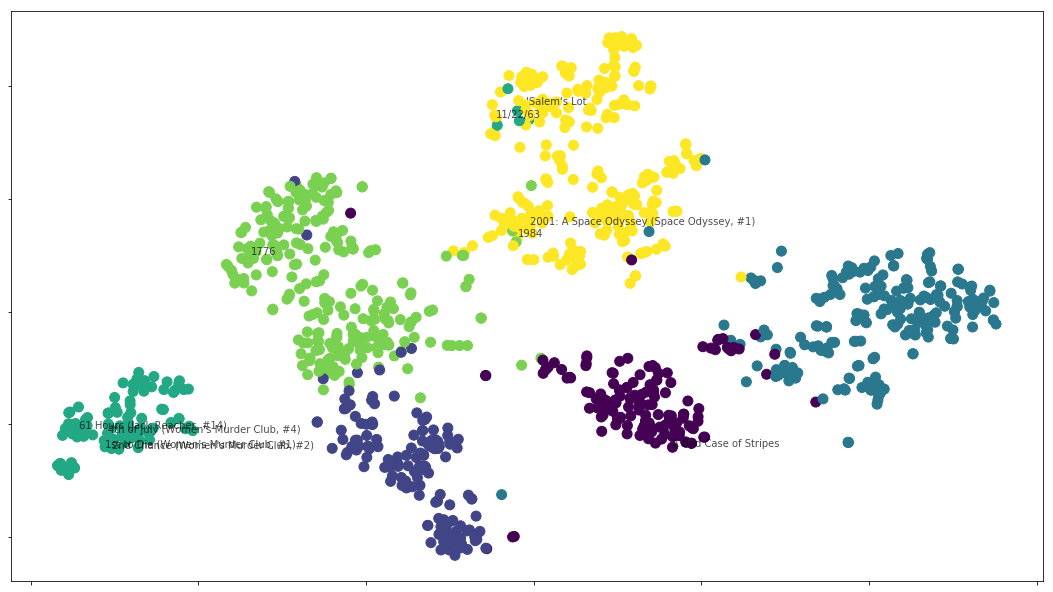

In [20]:
# Import TSNE
from sklearn.manifold import TSNE

# Create a TSNE instance: model
model = TSNE(learning_rate = 100)

# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(X)

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1st feature: ys
ys = tsne_features[:,1]

# Scatter plot, coloring by variety_numbers
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.scatter(xs, ys, c = labels,s=100)
for x, Y, book in zip(xs[:10], ys[:10], y[:10]):
    plt.annotate(book, (x, Y), fontsize=10, alpha=0.70)
plt.show()


In [24]:
#plotting using PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)

ml_df['pca-one'] = pca_result[:,0]
ml_df['pca-two'] = pca_result[:,1] 
ml_df['pca-three'] = pca_result[:,2]


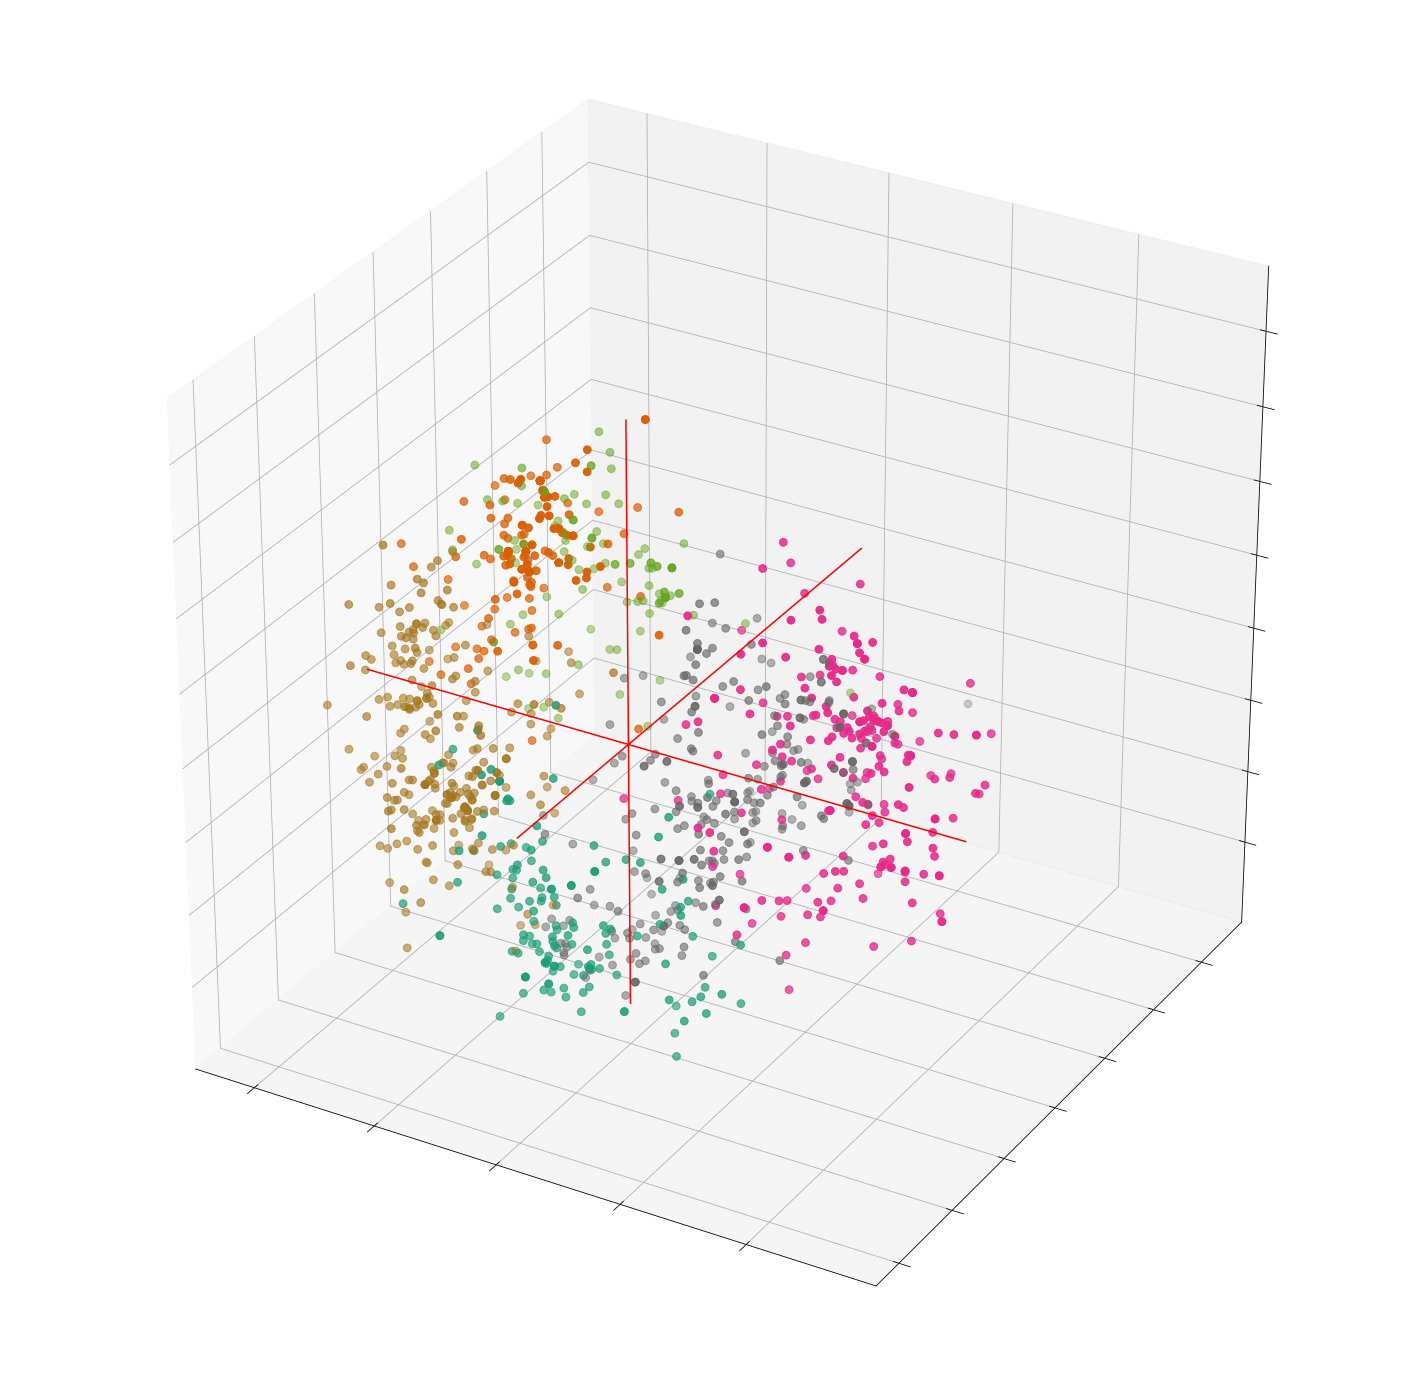

In [29]:
 
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ml_df['pca-one'], ml_df['pca-two'], ml_df['pca-three'], c=ml_df['labels'], cmap="Dark2", s=60)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(ml_df['pca-one']), max(ml_df['pca-one'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(ml_df['pca-two']), max(ml_df['pca-two'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(ml_df['pca-three']), max(ml_df['pca-three'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.zaxis.set_ticklabels([])

fig = plt.gcf()
fig.set_size_inches(25, 25)
plt.savefig('Poster3',dpi=150)
plt.show()
